In [1]:
import dataset_flickr
import dataset_flickr7k
import helper_classes as helper
import nltk
#nltk.download('punkt')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils import data as data
import model
import time 
import torch
import torch.nn as nn
import torch.optim as optim
import pathlib
import os 

In [2]:
CHECKPOINT_DIRECTORY = "model_checkpoints"

# Load Dataset

## Train set 

In [5]:
# dataset
data_args = {'stage': 'train',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 10}
#train_data = dataset_flickr.Flickr30kData(**data_args)
train_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(train_data)} images!") 

IndexError: list index out of range

## Validation set

In [ ]:
# dataset
data_args = {'stage': 'val',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 10}
#val_data = dataset_flickr.Flickr30kData(**data_args)
val_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(val_data)} images!") 

## Test set

In [3]:
# dataset
data_args = {'stage': 'test',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 10}
#test_data = dataset_flickr.Flickr30kData(**data_args)
test_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(test_data)} images!") 

stage:  test
ds_path:  /home/Datasets/flickr30k/
captions_f:  /home/Datasets/flickr30k/annotations/results_new.csv
imgs_dir:  /home/Datasets/flickr30k/images_split/test
Initialized 5472 words in vocabulary
Initialized 10000 images!


## Set up data loader

In [ ]:
pad_idx = train_data.vocabulary.str_to_idx["<PAD>"]
batch_size = 32 #100

train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


val_loader = DataLoader (
        dataset=val_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


test_loader = DataLoader(
        dataset=test_data,
        batch_size=  1,
        shuffle=True,
        #collate_fn=helper_classes.CollateCustom(pad_idx),
    )


In [4]:
test_loader = DataLoader(
        dataset=test_data,
        batch_size=  1,
        shuffle=True,
        #collate_fn=helper_classes.CollateCustom(pad_idx),
    )


# Set up hyperparameters

In [7]:
"""
TODO:
- need to figure out train/val batch size 
- caption length - how to set this param? 
"""
# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(test_data.vocabulary) #len(train_data.vocabulary)
num_layers = 1
learning_rate = 3e-4

#dont train CNN from scratch
#tune last layer 
extract_features = True



# Initialize Model, Loss & optimizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
import model
model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_data.vocabulary.str_to_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Initialized Encoder!
Initialized Decoder!


# Train model

In [61]:
"""
TODO:
add validation set? - DONE 
calculate average loss over batches 
"""
#import pathlib
CHECKPOINT_DIRECTORY = "model_checkpoints"

model.train()

start = 1
num_epochs = 6  #60 #ONLY USE MULTIPLES OF 10 
losses = [] 
losses_val = []

time_start = time.time() 

restore_latest_checkpoint = True

if restore_latest_checkpoint:
    #find last checkpoint file based on last modified 
    all_files = pathlib.Path(CHECKPOINT_DIRECTORY).glob('*.pth')
    latest_file = max(all_files, key=os.path.getctime)
    checkpoint_file = str(latest_file).split("/")[1]
    
    #adjust epoch range
    start = int(checkpoint_file.split("_")[2]) + 1 
    num_epochs += start 
    
    #load checkpoint 
    helper.load_checkpoint(checkpoint_file, model, optimizer)

for epoch in range(start, num_epochs+1):
        
        model.train()
        
        """
        Training
        """
        batch_loss = 0 
        avg_batch_loss = 0 
        ####UNCOMMENT THIS 
        for batch_num, (idx, X, y) in enumerate(train_loader):

            X = X.to(device)
            y = y.to(device)

            #torch.Size([48, 50, 7736]) 
            # 48 - max caption length of the batch 
            # 50 - batch size 
            #7736 - vocab_size 
            outputs = model(X, y[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), y.reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
            
            batch_loss += loss.item()

        #save loss after every epoch 
        #losses.append(loss.item())
        avg_batch_loss = batch_loss/(batch_num+1)
        
            
        """
        Validation
        """
        # run validation set to see find loss 
        batch_loss_val = 0 
        avg_batch_loss_val = 0 
        with torch.no_grad(): 
            #UNCOMMENT THIS 
            for batch_num_val, (idx_val, X_val, y_val) in enumerate(val_loader):
                X_val = X_val.to(device)
                y_val = y_val.to(device)


                #calculate loss
                out_val = model(X_val, y_val[:-1])
                loss_val = criterion(out_val.reshape(-1, out_val.shape[2]), y_val.reshape(-1))
                
                batch_loss_val += loss_val.item()

        #losses_val.append(loss_val.item())#{epoch : loss_val.item()})
        avg_batch_loss_val = batch_loss_val/(batch_num_val+1)

        losses.append([avg_batch_loss, avg_batch_loss_val])
        #losses.append([loss.item(), loss_val.item()])

            
        """
        Save checkpoints
        """ 
        #save every 10 epochs
        if True: #epoch%10 == 0:
            
            print(f"Training loss after {epoch} epochs: {loss.item()}\nValidation loss after {epoch} epochs: {loss_val.item()}")
            print("Time elapsed: {} min".format((round((time.time()-time_start)/60, 2))))
            #save checkpoint 
            checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch
                        }
            fname = "basic_model_" + str(epoch) + "_epochs.pth"
            #UNCOMMENT THIS 
            helper.save_checkpoint(checkpoint, fname)
                    
                
        #for final epoch 
        if epoch == num_epochs: 
            helper.save_model(model.state_dict(), "basic_model.pth")
             
print("Time elapsed for {} epochs: {} min".format(num_epochs, 
                                                  round((time.time()-time_start)/60, 2)))
print("loss: ", loss.item())

Loaded checkpoint basic_model_2_epochs.pth!
Training loss after 3 epochs: 3.4573605060577393
Validation loss after 3 epochs: 3.6923129558563232
Time elapsed: 11.6 min
Saved checkpoint basic_model_3_epochs.pth!
Training loss after 4 epochs: 3.352689027786255
Validation loss after 4 epochs: 3.4441003799438477
Time elapsed: 23.39 min
Saved checkpoint basic_model_4_epochs.pth!
Training loss after 5 epochs: 3.3793463706970215
Validation loss after 5 epochs: 3.778324604034424
Time elapsed: 35.14 min
Saved checkpoint basic_model_5_epochs.pth!
Training loss after 6 epochs: 3.3868114948272705
Validation loss after 6 epochs: 3.732893466949463
Time elapsed: 47.1 min
Saved checkpoint basic_model_6_epochs.pth!
Training loss after 7 epochs: 3.3455474376678467
Validation loss after 7 epochs: 3.666414737701416
Time elapsed: 65.12 min
Saved checkpoint basic_model_7_epochs.pth!


KeyboardInterrupt: 

## Plot loss 

<AxesSubplot:>

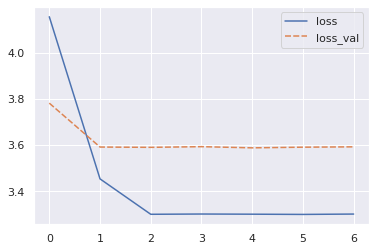

In [62]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
sns.set() 


if restore_latest_checkpoint: 
    #add to existing losses 
    old_losses = pd.read_csv('loss.csv')[["epochs", "loss", "loss_val"]]
    start_index = old_losses.epochs.max() + 1
    new_data = [[start_index+i, losses[i][0], losses[i][1]] for i in range(len(losses))]
    new_losses = pd.DataFrame(new_data, columns = ["epochs", "loss", "loss_val"])
    loss_df = pd.concat([old_losses, new_losses], keys = ["epochs", "loss", "loss_val"]).reset_index(drop = True)
    
else:
    #create new df 
    loss_df = pd.DataFrame(losses, columns = ['loss', "loss_val"])
    loss_df = loss_df.reset_index().rename(columns= {'index': 'epochs'})
    
loss_df.to_csv("loss.csv")

loss_df
sns.lineplot(data= loss_df.iloc[:, 1:])
#sns.lineplot(data = loss_df, x = "epochs", y = "loss") 

## Test random cases

In [10]:
import model 
#find last checkpoint file based on last modified 
CHECKPOINT_DIRECTORY = "model_checkpoints_didntwork"
all_files = pathlib.Path(CHECKPOINT_DIRECTORY).glob('*.pth')
latest_file = max(all_files, key=os.path.getctime)
checkpoint_file = str(latest_file).split("/")[1]

#print(checkpoint_file)

model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)

path =  CHECKPOINT_DIRECTORY + "/" + checkpoint_file
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["state_dict"])

model.eval()
None

Initialized Encoder!
Initialized Decoder!


In [77]:
#Load model for inference 
#import model
#model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
#helper.load_model(model, "basic_model.pth")

#basic_model_170_epochs.pth

#model.eval()
#None

In [29]:
import torch
torch.cuda.empty_cache()
import gc
#del variables
gc.collect()

221

In [26]:
idx, X, y= next(iter(test_loader))

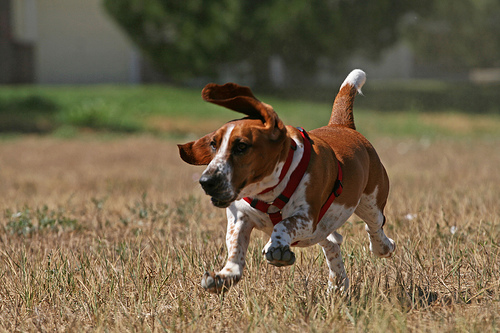

In [27]:
#train_data.plot_img(idx[0])
test_data.plot_img(idx.item())

In [28]:
"""
TODO: when calculating score, compare to any of the reference sentence?
"""
#print("Expected: ", train_data.get_all_captions(idx[0]))
#print("Predicted: ", model.caption_image(X[:1].to(device), train_data.vocabulary))


print("Expected: ", test_data.get_all_captions(idx.item()))
print("Predicted: ", model.caption_image(X.to(device), test_data.vocabulary, 22))

Expected:  ['A brown and white dog wearing a red harness is running through a dry field , ears flapping .', 'A dog with floppy ears runs in a dry field .', 'A dog runs in a field of brown grass .', 'A longeared dog running in the grass .', 'A dog bounds across the brown grass .']
Predicted:  ['<SOS>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'a', 'black', 'shirt', 'is', 'sitting', 'on', 'a', 'bench', '.', '<EOS>']


In [33]:
from PIL import Image as PILImage

fname = test_data.img_files_dict[idx.item()]
path = test_data.imgs_dir + '/' + fname 
img = PILImage.open(path).convert('RGB')

In [34]:
from torchvision import transforms as transforms

transform_train = transforms.Compose([ 
                transforms.Resize(256),                          # smaller edge of image resized to 256
               # transforms.RandomCrop(224),                      # get 224x224 crop from random location
                transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
                transforms.ToTensor(),                           # convert the PIL Image to a tensor
                transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                     (0.229, 0.224, 0.225))
]
            )
img = transform_train(img)

In [234]:
transform = transforms.Compose([
                transforms.Resize((299, 299)),
                transforms.ToTensor()
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img = transform(img)

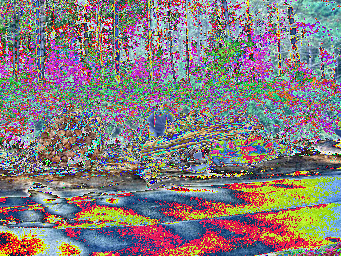

In [35]:
# define a transform to convert a tensor to PIL image
transform = transforms.ToPILImage()

# convert the tensor to PIL image using above transform
my_img= transform(img)

# display the PIL image
my_img.show()